


# Preprocesado




In [ ]:
#Cargamos las librerías necesarias
from google.colab import drive
import pickle
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
from typing_extensions import ParamSpecKwargs
from textblob import TextBlob, Word
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet') 
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import joblib
import random
import matplotlib.pyplot as plt
import sklearn.preprocessing as pr
from keras.preprocessing.text import Tokenizer
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Conectamos con drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
cache_dir = "/content/drive/MyDrive/Practica NLP/"


Leemos los datos

In [ ]:
def read_data(data_dir='dir',file_name = 'data'):
  f = open(data_dir+file_name,'rb')
  data = pickle.load(f)
  data = data[['reviewText','sentiment_label']]
  data = data.rename(columns = {'reviewText':'review','sentiment_label':'sentiment'} )
  return data

In [ ]:
data = read_data(data_dir=cache_dir,file_name = 'data.pkl')

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.head()

review  sentiment
0  Very oily and creamy. Not at all what I expect...          1
1  This palette was a decent price and I was look...          0
2  The texture of this concealer pallet is fantas...          0
3  I really can't tell what exactly this thing is...          1
4  It was a little smaller than I expected, but t...          0

Función para pasar las reviews a palabras

Vamos a pasarlo a minúsculas, a separarlo en palabras y eliminar los números. También eliminamos los signos de puntuación. Como es un análisis de sentimientos, no vamos a eliminar los stopwords.

In [ ]:
def review_to_words(text):
    text =re.findall(r"([a-z']+)", text.lower())
    s = TextBlob(' '.join(text))
    return [w.lemmatize() for w in s.words]


In [ ]:
#La idea era además pasarle un corrector léxico, pero no lo he podido aplicar por el tiempo de ejecución. 
def correct_words(text):
    return TextBlob(text).correct() 

In [ ]:
#Creamos una función que preprocese los datos. Le damos la opción de balancear, dado que la información está desbalanceada, y tenemos muchas reviews. Vamos a eliminar de forma aleatoria parte de las reviews
#positivas, con idea de balancear los datos y además reducir un poco el tamaño de la muestra.
#Le daremos la opción de coger de memoria los ficheros para que no tenga que hacer los cálculos si el fichero ya existe.
def preprocess_data(data,cache_dir,t_size, cache_file="preprocessed_data.pkl",balancear = None):

  cache_data = None
  if balancear == 'Si':
    cache_file="preprocessed_data_filter.pkl"

  if cache_file is not None:

    try:
       f = open(cache_dir+cache_file,'rb')
       cache_data = pickle.load(f)
       print("Fichero procesador cargado de la cache")

    except:

      pass

  if cache_data is None:
    if balancear is "Si":
       T_max= int((data['sentiment'].loc[ data['sentiment']==1].value_counts().values[0]/0.4)*0.6)
       data_filter = data.loc[ data['sentiment']==0].sample(n=T_max, random_state=42)
       data_filter = pd.concat([data_filter ,data.loc[ data['sentiment']==1]])
       data = shuffle(data_filter)
       data = data.reset_index(drop=True)

    #data['review'] = data['review'].apply(lambda x : ''.join(correct_words(x)))
    data_train, data_test, labels_train, labels_test = train_test_split(data['review'],data['sentiment'],train_size=t_size,test_size=1-t_size,random_state=42,shuffle=True,stratify=data['sentiment'])
                # Making our first textblob
    

    words_train = list(map(review_to_words, data_train))
    words_test = list(map(review_to_words, data_test))

    if cache_file is not None:
        cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
        with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
        print("Fichero creado en cache:", cache_file)
  else:
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
        
  return    words_train, words_test, labels_train, labels_test    


In [ ]:
words_train, words_test, labels_train, labels_test = preprocess_data(data,cache_dir ,0.75)

Fichero procesador cargado de la cache


In [ ]:
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])


--- Preprocessed words ---
['i', 'read', 'rave', 'review', 'about', 'gotu', 'kola', 'that', 'it', 'even', 'helped', 'varicose', 'vein', 'acne', 'etc', 'yes', 'it', 'did', 'give', 'my', 'husband', 'and', 'i', 'a', 'boost', 'of', 'alertness', 'and', 'i', 'thought', 'this', 'way', 'would', 'be', 'better', 'then', 'caffeine', 'however', 'we', 'both', 'realized', 'it', 'wa', 'causing', 'cystic', 'acne', 'a', 'day', 'or', 'after', 'i', 'would', 'take', 'a', 'dose', 'i', 'would', 'get', 'a', 'very', 'painful', 'annoying', 'pimple', 'we', 'threw', 'it', 'out']

--- Label ---
0


In [ ]:
words_train_filter, words_test_filter, labels_train_filter, labels_test_filter = preprocess_data(data,cache_dir ,0.75,balancear = 'Si')

Fichero creado en cache: preprocessed_data_filter.pkl


In [ ]:
print("\n--- Preprocessed words ---")
print(words_train_filter[1])
print("\n--- Label ---")
print(labels_train_filter[1])


--- Preprocessed words ---
['we', 'love', 'the', 'ease', 'of', 'this', 'and', 'are', 'thrilled', 'we', 'found', 'it', 'it', "'s", 'a', 'great', 'product', 'for', 'everyone', 'in', 'the', 'family']

--- Label ---
0


In [ ]:
#Check si funciona obteniendo los datos de la cache
words_train, words_test, labels_train, labels_test = preprocess_data(data,cache_dir ,0.75)

Fichero procesador cargado de la cache


In [ ]:
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])


--- Preprocessed words ---
['i', 'read', 'rave', 'review', 'about', 'gotu', 'kola', 'that', 'it', 'even', 'helped', 'varicose', 'vein', 'acne', 'etc', 'yes', 'it', 'did', 'give', 'my', 'husband', 'and', 'i', 'a', 'boost', 'of', 'alertness', 'and', 'i', 'thought', 'this', 'way', 'would', 'be', 'better', 'then', 'caffeine', 'however', 'we', 'both', 'realized', 'it', 'wa', 'causing', 'cystic', 'acne', 'a', 'day', 'or', 'after', 'i', 'would', 'take', 'a', 'dose', 'i', 'would', 'get', 'a', 'very', 'painful', 'annoying', 'pimple', 'we', 'threw', 'it', 'out']

--- Label ---
0


In [ ]:
#Check si funciona obteniendo los datos filtrados de la cache
words_train_filter, words_test_filter, labels_train_filter, labels_test_filter = preprocess_data(data,cache_dir ,0.75,balancear = 'Si')

Fichero procesador cargado de la cache


In [ ]:
print("\n--- Preprocessed words ---")
print(words_train_filter[1])
print("\n--- Label ---")
print(labels_train_filter[1])


--- Preprocessed words ---
['we', 'love', 'the', 'ease', 'of', 'this', 'and', 'are', 'thrilled', 'we', 'found', 'it', 'it', "'s", 'a', 'great', 'product', 'for', 'everyone', 'in', 'the', 'family']

--- Label ---
0


In [ ]:
#Generamos también una función que haga un countvectorizers, usaremos en los modelos como la regresión logística.
#Le damos la opción de balancear, pero en este caso simplemente, es para saber que fichero estamos trabajando, y no pisarlos.
def extract_BoW_features(words_train, words_test,vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl",balancear = None):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    if balancear =='Si':
       cache_file="bow_features_filter.pkl"
    
    cache_data = None
    if cache_file is not None:
        try:
 
            with open(cache_dir+cache_file,'rb') as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass
    
    if cache_data is None:
        vectorizer = CountVectorizer(max_features=vocabulary_size,min_df = 3,max_df = 1.0,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        features_test = vectorizer.transform(words_test).toarray()
                
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    return features_train, features_test, vocabulary





In [ ]:
#Por problemas de memoria no puedo ejecutar con el total de la muestra, por lo que de aquí en adelante trabajaré con la muestra balanceada
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)
print("Vocabulary: {} words".format(len(vocabulary)))
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

In [ ]:
features_train_filter, features_test_filter, vocabulary_filter = extract_BoW_features(words_train_filter, words_test_filter,balancear = 'Si')

Read features from cache file: bow_features_filter.pkl


In [ ]:
print("Vocabulary: {} words".format(len(vocabulary_filter)))
print("Sample words: {}".format(random.sample(list(vocabulary_filter.keys()), 8)))

print("\n--- Preprocessed words ---")
print(words_train_filter[5])
print("\n--- Bag-of-Words features ---")
print(features_train_filter[5])
print("\n--- Label ---")
print(labels_train_filter[5])

Vocabulary: 5000 words
Sample words: ['pale', 'watery', 'upright', 'foamy', 'advertises', 'seeking', 'glycol', 'determine']

--- Preprocessed words ---
['dementia', 'run', 'in', 'my', 'family', 'so', 'i', 'decided', 'after', 'some', 'research', 'that', 'fish', 'oil', 'would', 'be', 'a', 'good', 'supplement', 'to', 'keep', 'my', 'brain', 'healthy', 'i', "'ve", 'tried', 'numerous', 'variety', 'and', 'always', 'had', 'the', 'same', 'problem', 'disgusting', 'foul', 'tasting', 'burp', 'i', 'might', 'have', 'given', 'up', 'but', 'a', 'friend', 'recommended', 'the', 'dr', 'tobias', 'brand', 'and', 'i', "'m", 'so', 'glad', 'i', 'listened', 'this', 'product', 'is', 'exactly', 'what', 'i', 'wa', 'looking', 'for', 'i', 'have', "n't", 'burped', 'it', 'up', 'i', 'have', "n't", 'tasted', 'it', 'in', 'the', 'back', 'of', 'my', 'throat', 'i', 'take', 'one', 'gel', 'cap', 'in', 'the', 'morning', 'and', 'that', "'s", 'it', 'i', 'do', "n't", 'have', 'to', 'think', 'about', 'it', 'again', 'another', 'revi

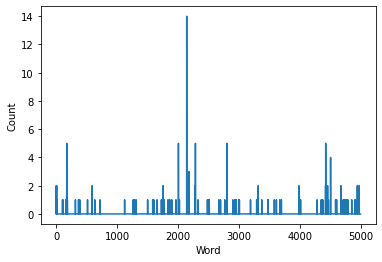

In [ ]:
plt.plot(features_train_filter[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

Vemos que hay muchas palabras que se repiten una sola vez

In [ ]:
#También creamos una función para tokenizar, cuyo resultado usaremos como inputs en los modelos de deep learning. De nuevo le damos la opción de 
# balancear, que de nuevo es para saber con que fichero trabajamos y no pisarlo.
def tokenize(words_train, words_test,cache_dir=cache_dir, cache_file="tokenizar_features.pkl",balancear = None):
  
    if balancear =='Si':
       cache_file="Tokenizar_features_filter.pkl"
    
    cache_data = None
    if cache_file is not None:
        try:
 
            with open(cache_dir+cache_file,'rb') as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass
    
    if cache_data is None:
        
        t= Tokenizer(num_words=10000)
        t.fit_on_texts(words_train)

        words_tokenizer_train = t.texts_to_sequences(words_train)
        words_tokenizer_test = t.texts_to_sequences(words_test)
        vocabulary_size = len(t.word_index)

        if cache_file is not None:
            
            cache_data = dict(words_tokenizer_train=words_tokenizer_train, 
                             words_tokenizer_test=words_tokenizer_test, vocabulary_size = vocabulary_size)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        words_tokenizer_train, words_tokenizer_test, vocabulary_size = (cache_data['words_tokenizer_train'],
                cache_data['words_tokenizer_test'], cache_data['vocabulary_size'])
    
    return words_tokenizer_train, words_tokenizer_test, vocabulary_size
  
  

In [ ]:
words_tokenizer_train, words_tokenizer_test, vocabulary_size = tokenize(words_train_filter, words_test_filter,balancear = 'Si')

Wrote features to cache file: Tokenizar_features_filter.pkl


In [ ]:
print("\n--- words ---")
print(words_train_filter[5])
print("\n--- words tokenizer---")
print(words_tokenizer_train[5])



--- words ---
['dementia', 'run', 'in', 'my', 'family', 'so', 'i', 'decided', 'after', 'some', 'research', 'that', 'fish', 'oil', 'would', 'be', 'a', 'good', 'supplement', 'to', 'keep', 'my', 'brain', 'healthy', 'i', "'ve", 'tried', 'numerous', 'variety', 'and', 'always', 'had', 'the', 'same', 'problem', 'disgusting', 'foul', 'tasting', 'burp', 'i', 'might', 'have', 'given', 'up', 'but', 'a', 'friend', 'recommended', 'the', 'dr', 'tobias', 'brand', 'and', 'i', "'m", 'so', 'glad', 'i', 'listened', 'this', 'product', 'is', 'exactly', 'what', 'i', 'wa', 'looking', 'for', 'i', 'have', "n't", 'burped', 'it', 'up', 'i', 'have', "n't", 'tasted', 'it', 'in', 'the', 'back', 'of', 'my', 'throat', 'i', 'take', 'one', 'gel', 'cap', 'in', 'the', 'morning', 'and', 'that', "'s", 'it', 'i', 'do', "n't", 'have', 'to', 'think', 'about', 'it', 'again', 'another', 'reviewer', 'mentioned', 'the', 'free', 'yoga', 'video', 'i', 'have', "n't", 'checked', 'those', 'out', 'yet', 'but', 'i', 'look', 'forward', 